# Executing Job on Pasqal hardware

In [1]:
import numpy as np
from threading import Thread

from qat.qpus import RemoteQPU

Simulation on Pasqal hardware and software can be performed using [Pulser](https://pulser.readthedocs.io/). This notebook first presents how to generate a `Job` that can be executed on Pasqal hardware from a Pulser `Sequence`, before showing how to execute it using Pasqal hardware. 

## Generating a Job to execute on Pasqal hardware

In [2]:
from pulser import Pulse, Sequence
from pulser.waveforms import CustomWaveform
from pulser.devices import AnalogDevice
from pulser_myqlm import IsingAQPU, FresnelQPU
from pulser_myqlm.myqlmtools import are_equivalent_schedules

On Pulser we can solve problems of shape 
$$ H = \hbar \sum_i \frac{\Omega(t)}{2}(\cos(\phi) \sigma_i^x - \sin(\phi) \sigma_i^y) - \frac{\delta(t)}{2}\sigma_i^z + \frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$$
with $\sigma_i^x$, $\sigma_i^y$, $\sigma_i^z$ the Pauli operators $X$, $Y$, $Z$ applied on qubit $i$ and $n_i = \frac{1+\sigma_i^z}{2}$.

This Hamiltonian is named the <u>Ising Hamiltonian</u>. It is composed of a time-independent part, $\frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$, and the rest of the terms that make a time-dependent Hamiltonian. In Pulser, this Hamiltonian is generated via a `Sequence` object. It is initialized by a `Device` and a `Register` that define the coefficients $U_{ij}$. Then, `Pulse`s are added to this `Sequence` to generate the time-dependent terms of this Hamiltonian. You can find more information about this Ising Hamiltonian in the [Pulser documentation](https://pulser.readthedocs.io/en/stable/review.html).  

The [pulser-myqlm package](https://github.com/pasqal-io/Pulser-myQLM) and its `IsingAQPU` class enables you to convert a Pulser Sequence into a MyQLM `Schedule` or `Job`. Let's start by generating a `Job` from a `Sequence`, before simulating it using Pasqal's hardware and software tools. 

### Converting a Pulser Sequence into a Schedule or Job

A Pulser `Sequence` starts by defining a `Device` and a `Register`.

Pulser provides examples of Pasqal devices in `pulser.devices`. Any of these devices can be used for simulation purposes, yet the device representing best Pasqal QPUs is `AnalogDevice`. 

In real pulser devices, only some `Register` can be implemented. They must be built from a `RegisterLayout` in the `calibrated_register_layouts` of the `Device`. Let's have a look to one of the calibrated layouts of `AnalogDevice`:

{'TriangularLatticeLayout(61, 5.0µm)': RegisterLayout_f771cf8ed8632985d8a9932015027bd73e90391c049e8a8591e2c663febcaafe}


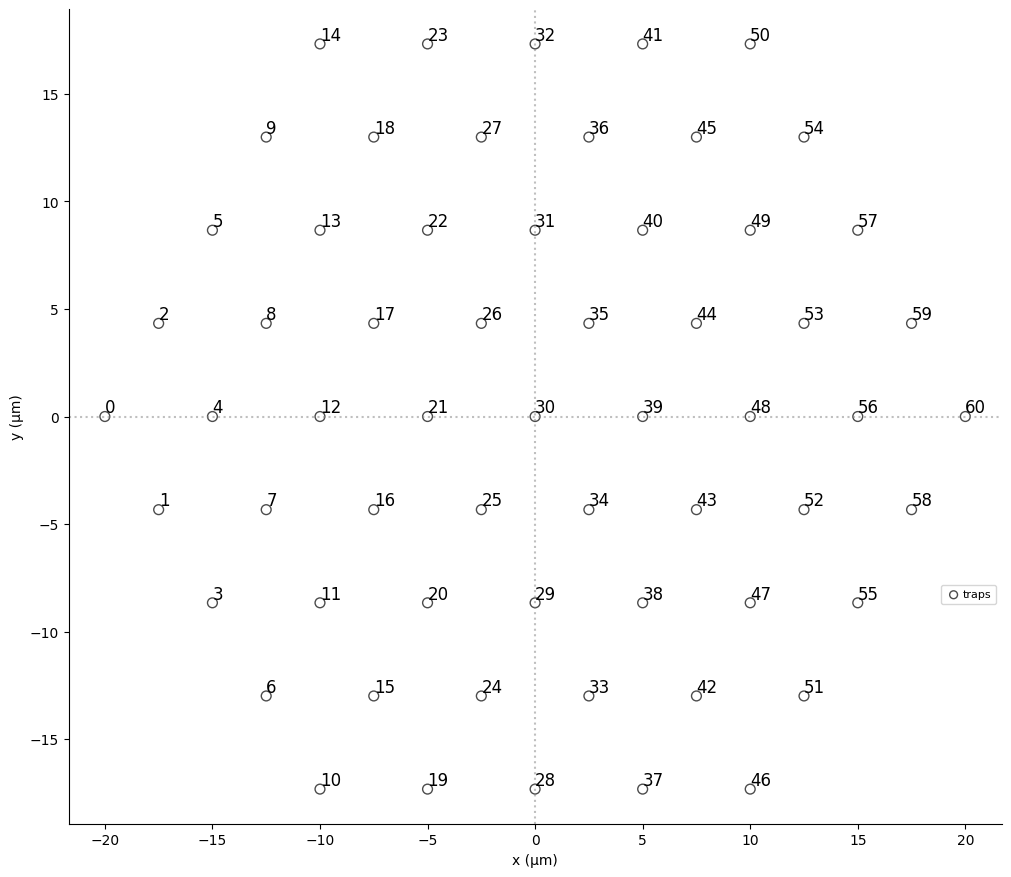

In [3]:
print(AnalogDevice.calibrated_register_layouts)
analog_layout = AnalogDevice.calibrated_register_layouts[
    "TriangularLatticeLayout(61, 5.0µm)"
]
analog_layout.draw()

The registers must be a subset of the calibrated layouts of `AnalogDevice`. They must be defined using the `define_register` method of the layouts. You can read more about registers and layouts [in the pulser documentation](https://pulser.readthedocs.io/en/stable/tutorials/reg_layouts.html).

Let's define a Register of triangular shape with sites 26, 35 and 30. The sites are spaced by 5µm.

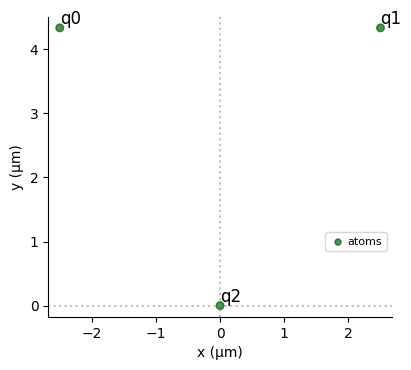

In [4]:
register = analog_layout.define_register(26, 35, 30)
register.draw()

Let's now build a `Sequence` with this `Register` and `AnalogDevice`. Pasqal QPUs and `AnalogDevice` supports only one channel, a `Rydberg.Global` channel. Pulses can be added to this channel to generate the Ising Hamiltonian described above. They are composed of a Rabi frequency $\Omega$ (in $rad/\mu s$), a detuning $\delta$ (in $rad/\mu s$) and a phase $\phi$ (in $rad$) and are defined every $ns$. 

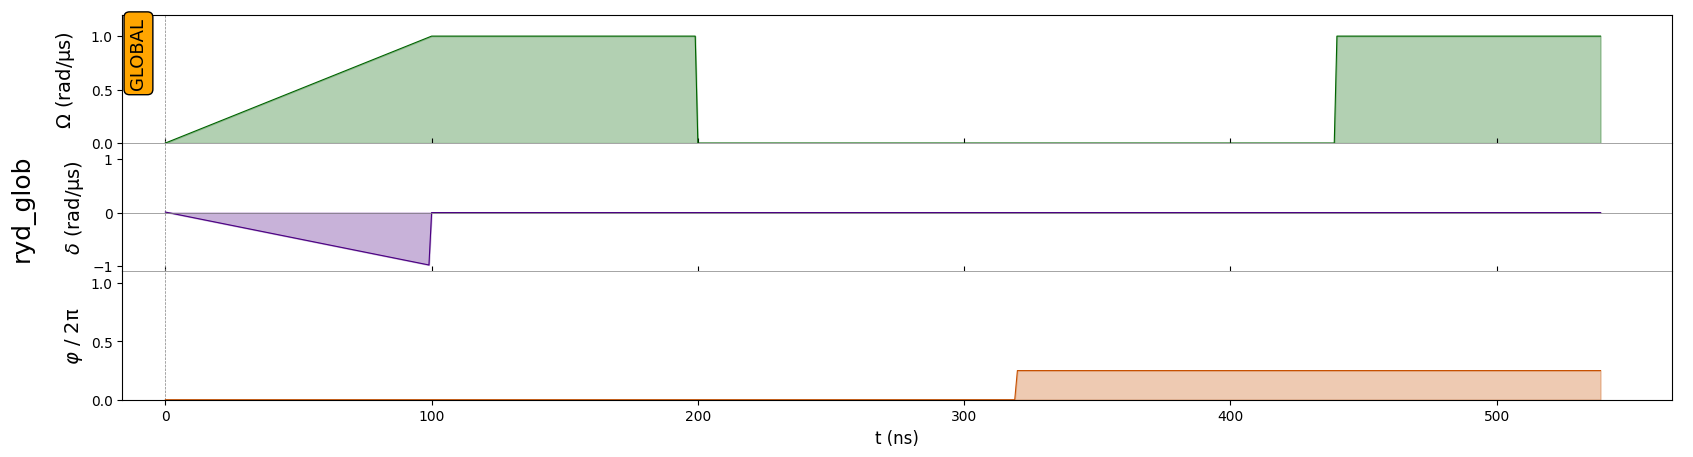

In [5]:
t0 = 100  # in ns
seq = Sequence(register, AnalogDevice)
seq.declare_channel("ryd_glob", "rydberg_global")
# no parametrized sequence for the moment
seq.add(
    Pulse(
        CustomWaveform([ti / 100 for ti in range(t0)]),  # in rad/µs
        CustomWaveform([(1 - ti) / 100 for ti in range(t0)]),  # in rad/µs
        0,  # in rad
    ),
    "ryd_glob",
)  # corresponds to H0
seq.add(Pulse.ConstantPulse(t0, 1, 0, 0), "ryd_glob")  # corresponds to H1
seq.add(Pulse.ConstantPulse(t0, 1, 0, np.pi / 2), "ryd_glob")  # corresponds to H2
seq.draw(mode="input", draw_phase_curve=True)

The class methods `IsingAQPU.convert_sequence_to_schedule` and `IsingAQPU.convert_sequence_to_job` performs the direct conversion from a `Sequence` to a `Schedule` or `Job`. One can verify that the created `Schedule` has the shape of the Ising Hamiltonian defined above, with time-dependent coefficients in front of local `X`, `Y`, `Z` gates applied on qubits 0, 1 and 2, and `ZZ` interactions between the qubits. The Ising Hamiltonian being defined in $rad/\mu s$, the time in the `Schedule` is defined in $\mu s$ for this schedule to be simulated in `AnalogQPU` or `QutipQPU`.  

In [6]:
schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(seq)
print(schedule_from_seq)

drive:
1 * ((get_item([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

The pulses of the `Sequence` are the instructions sent to the hardware. If you want a model of the behaviour of the hardware, you should convert while setting the `modulation` argument to `True`. You can learn more about modulation [in the Pulser documentation](https://pulser.readthedocs.io/en/stable/tutorials/output_mod_eom.html).

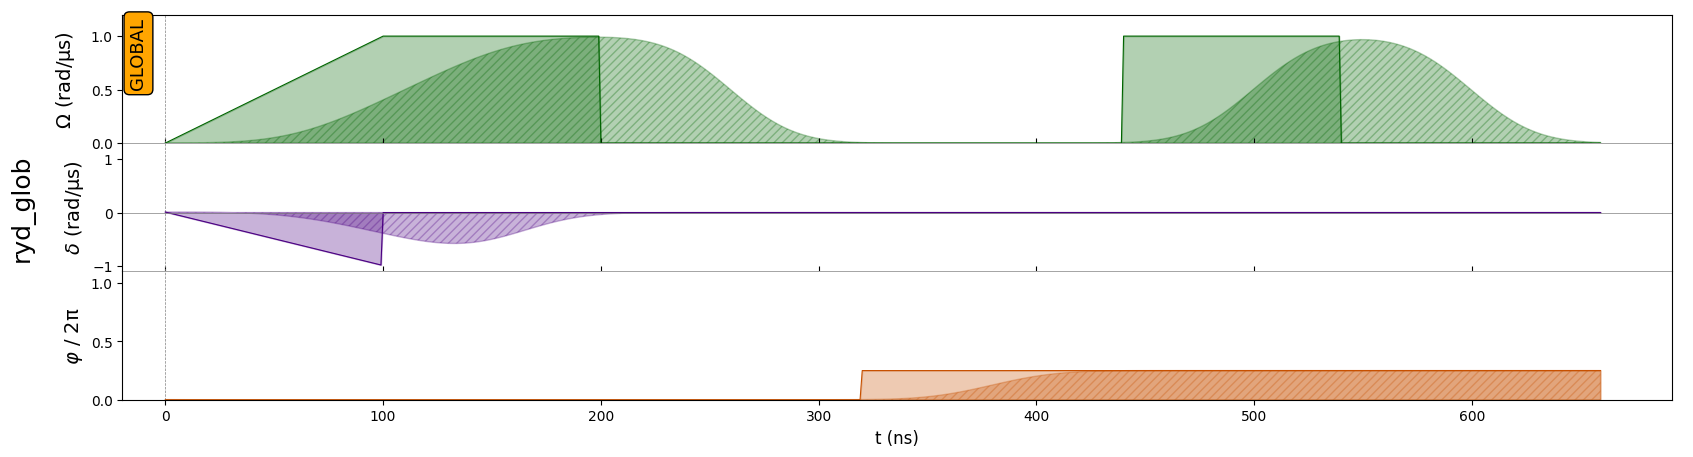

drive:
1 * ((get_item([0.005283597381893872, 0.004765372895744332, 0.004315107656678695, 0.003927990387293574, 0.0035996983157872042, 0.0033263839295578097, 0.003104661053788537, 0.0029315904694360417, 0.002804665259586223, 0.002721796047457271, 0.0026812962637856232, 0.002681867556282461, 0.002722585429591739, 0.002802885180990441, 0.002922548175179429, 0.0030816884811348234, 0.0032807398752625777, 0.0035204431981968706, 0.0038018340375747437, 0.004126230696102464, 0.004495222393248387, 0.004910657639970118, 0.0053746327190134354, 0.00588948019849372, 0.0064577574036343835, 0.0070822347706327934, 0.007765884007586642, 0.008511865990138635, 0.009323518323873453, 0.010204342511428951, 0.011157990669600572, 0.012188251750302045, 0.01329903722893607, 0.014494366234355212, 0.015778350105988274, 0.017155176375704982, 0.018629092184383616, 0.02020438715577301, 0.02188537576289553, 0.023676379234743774, 0.025581707063186482, 0.027605638181652636, 0.02975240189810683, 0.0320261586749175, 0.034

In [7]:
# Samples of the Sequence are in full line, modulated samples in hatched
# mod_schedule_from_seq contains the modulated samples of the analog_seq
seq.draw(draw_phase_curve=True)
mod_schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(seq, modulation=True)
print(mod_schedule_from_seq)

It is also possible to convert the Pulser `Sequence` directly into a job using `IsingAQPU.convert_sequence_to_job`. You can define the number of shots of the job in the attribute `nbshots`. The default value asks for the maximum number of shots the device can take.

In [8]:
job_from_seq = IsingAQPU.convert_sequence_to_job(seq, nbshots=1000, modulation=True)
print(job_from_seq)

Job(circuit=None, schedule=Schedule(tname='t', drive_obs=[Observable(terms=[Term(_coeff=TNumber(is_abstract=True, type=None, int_p=None, double_p=None, string_p='* / get_item [0.005283597381893872,0.004765372895744332,0.004315107656678695,0.003927990387293574,0.0035996983157872042,0.0033263839295578097,0.003104661053788537,0.0029315904694360417,0.002804665259586223,0.002721796047457271,0.0026812962637856232,0.002681867556282461,0.002722585429591739,0.002802885180990441,0.002922548175179429,0.0030816884811348234,0.0032807398752625777,0.0035204431981968706,0.0038018340375747437,0.004126230696102464,0.004495222393248387,0.004910657639970118,0.0053746327190134354,0.00588948019849372,0.0064577574036343835,0.0070822347706327934,0.007765884007586642,0.008511865990138635,0.009323518323873453,0.010204342511428951,0.011157990669600572,0.012188251750302045,0.01329903722893607,0.014494366234355212,0.015778350105988274,0.017155176375704982,0.018629092184383616,0.02020438715577301,0.0218853757628955

## Simulating a Job on Pasqal hardware and simulation tools

Any `Job` implementing an Ising Hamiltonian can be simulated using a local or remote QPU of Qaptiva Access by using its `submit` method. The only condition on this QPU is that it must be able to simulate [Analog Jobs](https://myqlm.github.io/02_user_guide/01_write/02_analog_schedule/03_an_jobs.html).

A Job encapsulating a serialized Pulser `Sequence` under the key "abstr_dict" of the dictionary `Job.schedule._other` can be simulated using Pasqal hardware and simulation tools.

`IsingAQPU` has a `submit` method that can be used to simulate the sequence either using `pulser_simulation` or another qpu.

### Simulating a Job using pulser-simulation locally

Prior to submitting a `Job` to a `QPU`, it is good practice to test that its execution works well. With `pulser_simulation`, you can simulate a Pulser Sequence. More details can be found [here](https://pulser.readthedocs.io/en/stable/tutorials/simulating.html).

To simulate a MyQLM `Job` locally using `pulser-simulation`, you first have to create an `IsingAQPU` using its `from_sequence` method and by setting its qpu to `None`. Once the `IsingAQPU` created, the results are obtained by submitting it the `Job` to simulate:

In [9]:
# Create an IsingAQPU
simulation_aqpu = IsingAQPU.from_sequence(seq, qpu=None)
# Simulate the sequence
# If job was converted from the sequence using modulation=True,
# modulated samples of the sequence are used for the simulation
result_from_pulser = simulation_aqpu.submit(job_from_seq)
print("Result is:", result_from_pulser, "\n")
print(
    r"Expressed as {state: probability}:",
    {sample.state: sample.probability for sample in result_from_pulser},
)

Result is: Result(need_flip=False, lsb_first=False, nbqbits=None, has_statevector=False, statevector=None, data=None, _value=None, raw_data=[Sample(_amplitude=None, probability=0.982, _state=0, err=None, intermediate_measurements=None, qregs=[QRegister(scope=None, length=3, start=0, msb=None, _subtype_metadata=None, qbits=[<qat.lang.AQASM.bits.Qbit object at 0x0000019076D05340>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076D053A0>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076D05400>])]), Sample(_amplitude=None, probability=0.007, _state=1, err=None, intermediate_measurements=None, qregs=[QRegister(scope=None, length=3, start=0, msb=None, _subtype_metadata=None, qbits=[<qat.lang.AQASM.bits.Qbit object at 0x0000019076D05340>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076D053A0>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076D05400>])]), Sample(_amplitude=None, probability=0.004, _state=2, err=None, intermediate_measurements=None, qregs=[QRegister(scope=None, length=3, start=0

### Executing a Job on a FresnelQPU

The `FresnelQPU` class is a `QPUHandler` that interfaces a QPU. It should be instantiated on the same network as the QPU, using its public address. If the public address is set to `None`, the `FresnelQPU` uses pulser-simulation to simulate the `Job`:

In [10]:
fresnel_qpu = FresnelQPU(base_uri=None, version="v1")
print("The QPU is operational: ", fresnel_qpu.is_operational)

The QPU is operational:  True


To submit a MyQLM job to `FresnelQPU`, you need to furnish a serialized Pulser `Sequence` in `Job.schedule._other`. This `Sequence` must use a device compatible with the performances of the QPU. The device associated with the `FresnelQPU` is accessible via the `device` attribute. `AnalogDevice` has the same main properties as this device, but can enable the use of pulses with higher amplitudes or detunings.

In [11]:
print("Device used is", fresnel_qpu.device, "\n")
result_from_qpu = fresnel_qpu.submit(job_from_seq)
print("Result is:", result_from_qpu, "\n")
print(
    r"Expressed as {state: probability}:",
    {sample.state: sample.probability for sample in result_from_qpu},
)

Device used is Fresnel 

Result is: Result(need_flip=False, lsb_first=False, nbqbits=None, has_statevector=False, statevector=None, data=None, _value=None, raw_data=[Sample(_amplitude=None, probability=0.975, _state=0, err=None, intermediate_measurements=None, qregs=[QRegister(scope=None, length=3, start=0, msb=None, _subtype_metadata=None, qbits=[<qat.lang.AQASM.bits.Qbit object at 0x0000019076C57490>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076C57C70>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076C579A0>])]), Sample(_amplitude=None, probability=0.011, _state=1, err=None, intermediate_measurements=None, qregs=[QRegister(scope=None, length=3, start=0, msb=None, _subtype_metadata=None, qbits=[<qat.lang.AQASM.bits.Qbit object at 0x0000019076C57490>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076C57C70>, <qat.lang.AQASM.bits.Qbit object at 0x0000019076C579A0>])]), Sample(_amplitude=None, probability=0.008, _state=2, err=None, intermediate_measurements=None, qregs=[QRegister(scop

### Simulating a Job remotly on a FresnelQPU

To access the QPU remotly, it has to be deployed on a server. You can deploy `FresnelQPU` on a Qaptiva server via its `serve` method. Any user can then access this QPU via a `RemoteQPU`:

In [12]:
# Deploy the QPU on a Qaptiva server
server_thread = Thread(target=fresnel_qpu.serve, args=(1234,))
server_thread.start()
# Access it remotly
qpu = RemoteQPU(1234, "localhost")

Running the QPU server on localhost:1234


Users can simulate jobs remotly via the `submit` method of the `RemoteQPU` defined above or by defining a new QPU in `IsingAQPU` and submitting the job to it:

In [13]:
simulation_aqpu.set_qpu(qpu)
result_from_remote = simulation_aqpu.submit(job_from_seq)
print("Result is:", result_from_remote, "\n")
print(
    r"Expressed as {state: probability}: ",
    {sample.state: sample.probability for sample in result_from_remote},
)

Result is: Result(raw_data=[Sample(_state=0, probability=0.975, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=3, start=0, msb=None, _subtype_metadata=None, key=None)]), Sample(_state=1, probability=0.01, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=3, start=0, msb=None, _subtype_metadata=None, key=None)]), Sample(_state=2, probability=0.004, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=3, start=0, msb=None, _subtype_metadata=None, key=None)]), Sample(_state=4, probability=0.011, _amplitude=None, intermediate_measurements=None, err=None, qregs=[DefaultRegister(length=3, start=0, msb=None, _subtype_metadata=None, key=None)])], _value=None, error=None, value_data=None, error_data=None, meta_data={'n_samples': '1000', 'n_qubits': '3'}, in_memory=None, data=None, qregs=[DefaultRegister(length=3, start=0, msb=None, _subtype_metadata=None, key=None)], _parameter_m